# Sedimentation Experiments

In this notebook, we perform sedimentation experiments to benchmark the pIBM for droplets and rigid bodies. Following Kim & Peskin (Phys. Fluids 28, 033603 (2016); https://doi.org/10.1063/1.4944565), we apply gravity as a body force and apply an updraft to keep the body in the computational domain. 

In [2]:
#### Script for IBM simulation of a single droplet in incompressible, periodic fluid
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

%matplotlib notebook 

from fluid2 import FLUID    #### Generic fluid solver
from ib2 import IB2         #### 2D Immersed Boundary object (droplet membrane)
from pib2 import PIB2       #### 2D penalty IB object (droplet interior)
from rpib2 import RPIB2       #### 2D penalty IB object (rigid body)

from util import *          #### General functions (iterate, geometry, force functions, etc)
import warnings; warnings.simplefilter('ignore')

## Parameters

We declare default values of many parameters up front, including
- Fluid Parameters - Domain space/length scale and resolution; fluid density rho and viscosity mu
- Solid Parameters - mass/elasticity, position/size, and spacial resolution of immersed bodies
- Force Parameters - to tune gravity and updraft mechanism (see below)

Note that we can use lists of parameters to later initialize several immersed bodies using list comprehension - see simulation code. 

In [11]:
global dt, nsteps, nmod
# Fluid Parameters
L = 1.0                 # Domain Length
N = 128                 # Domain Points (NxN grid)
mu = 0.1               # viscosity
dt = 0.0005             # timestep
nsteps = 250            # simulation time 
nmod = 10               # save every nmod frames

%matplotlib notebook
def RESOLVE(res):
    global dt, nsteps, nmod
    dt/=res
    nsteps=int(nsteps*res)
    nmod=int(nmod*res)

RESOLVE(2)
# Membrane Parameters
K = 500
Nb = 400
rad = 0.05
positions = [[0.5, 0.5]]    
# rad = [0.05, 0.1]
# positions = [[0.2, 0.2], [0.6, 0.6]]

# Interior Parameters
Kp = 7000
M = 0.01
Ni = 300
    

Traceback (most recent call last):
  File "/home/users6/zds241/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/users6/zds241/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


## Gravity and Updraft
Our sedimentation experiments follow Kim & Peskin's 2016 paper, "A penalty immersed boundary method
for a rigid body in fluid". Following their procedure, we generate an updraft to keep the particle inside of the domain and to increase stability. 

In [12]:
# Body Force Parameters
z0=0.5
gamma=1e5
sigma=1e4

def GRAV(solid, Y, g=980.):
    F = np.zeros(np.shape(Y))
    F[:,1] -= g*solid.M
    return F

def UPDRAFT(z, w, z0=0.5, gamma=1e5, sigma=1e4): return gamma*(z0-z) - sigma*w


# PIBM Droplet Sedimentation

Droplets can be modeled using a massive interior fluid surrounded by an external elastic membrane. The interior mass markers follow a penalty IBM scheme, and the membrane follows the conventional IBM for an immersed body.

To set up a simulation, we define a method to instantiate an interior and exterior corresponding to given parameters, and a method to iterate the fluid and solids in time with the updraft described above.


In [13]:
#### Define a pIBM droplet using geometry from util
def pibDROPLET(fluid, RAD, POS, Nb=400, K=40, Ni=200, Kp=2500, M=None):
#     X_in = FULL_CIRCLE(RAD-fluid.h/2, POS, Ni)
    X_in = SUNFLOWER(RAD-fluid.h/2, POS, n=Ni)
    X_out = CIRCLE(RAD, POS, Nb)
    drop_in= PIB2(X_in, fluid.N, fluid.h, fluid.dt)
    drop_in.Kp = Kp    
    drop_in.M = M or drop_in.M
    drop_out = IB2(X_out, fluid.N, fluid.h, fluid.dt)
    drop_out.K = K
    return [drop_in, drop_out]



#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids):
    ff = 0. 
    ## Force density on fluid
    for solid in solids:
        solid.step_XX(fluid.u)
        ff += solid.ff         # Force at midpoint
    ff[1][:, -1] += UPDRAFT(np.mean(solids[0].Y, axis=0)[1], np.mean(solids[0].V, axis=0)[1], z0=z0, gamma=gamma, sigma=sigma)
    uu=fluid.step_u(ff)        # Step Fluid Velocity
    for solid in solids:
        solid.step_X(uu)       # full step using midpoint velocity    


In [14]:
####################################
  ########   Simulation   ########
####################################

#### Initialize Fluid+Droplets
fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
droplets = [pibDROPLET(fluid, rad, positions[i], Nb=Nb, K=K, Ni=Ni, Kp=Kp, M=M) for i in range(len(positions))]
# rad = [0.05, 0.1]
# droplets = [pibDROPLET(fluid, rad[i], positions[i], h=fluid.h/2, K=K, Kp=Kp, Nb=Nb, M=M) for i in range(len(positions))]

insides = [drop[0] for drop in droplets]
outsides = [drop[1] for drop in droplets]

solids = []
trash = [solids.extend(drop) for drop in droplets]

#### Declare Forces
for inside in insides:
    inside.bForce = lambda solid, Y:  GRAV(solid, Y)
    
    
    
#### Values that we're tracking
delta = [[] for inside in insides]    ## Keep track of |X-Y|/h
V = [[] for inside in insides]
# THETA = [[] for outside in outsides]

U = []
Xout = [[] for outside in outsides]
Xin = [[] for inside in insides]
Y = [[] for inside in insides]
for i in range(nsteps+1):
    iterate(fluid, solids)
    #### Keeping track of 'interior' properties
    for j, iin in enumerate(insides):
        delta[j].append(np.max(np.linalg.norm(iin.Y - iin.X, axis=1)))
        V[j].append(np.mean(iin.V, axis=0))
    if i%nmod==0:
        print(i)
        U.append(fluid.u.copy())
        for j, iin in enumerate(insides):
            Xin[j].append(iin.X.copy())
            Y[j].append(iin.Y.copy())
        for j, out in enumerate(outsides):
            Xout[j].append(out.X.copy())

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500


<IPython.core.display.Javascript object>


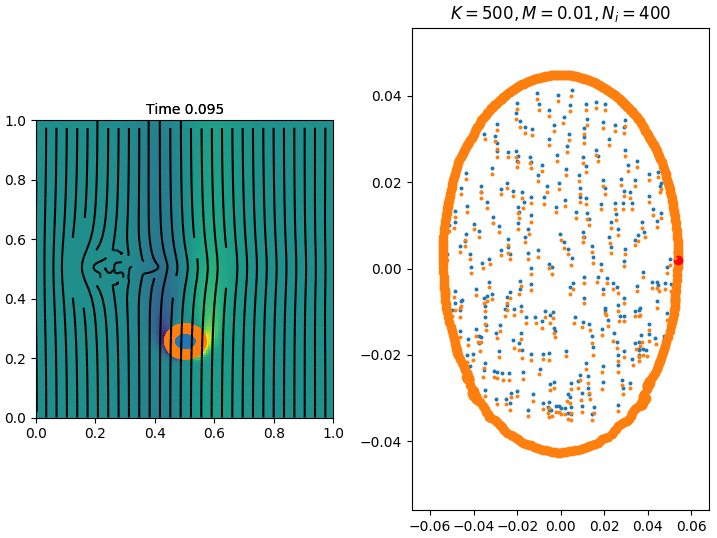

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500


In [15]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    print(i*nmod)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin, Xout]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        xout = Xout[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com
        out = xout - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
        im.append(axj.scatter(out[:,0], out[:,1], color=cmap(1)))
        im.append(axj.scatter([out[0,0]], [out[0,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')


In [16]:
ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)

In [17]:
ani2.save('Droplet_sed_2.gif')

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


# Rigid Body Sedimentation

In [6]:
def iterate(fluid, solids):
    ff = 0. ## Force density on fluid
    for solid in solids:
        solid.step_XX(fluid.u)
        ff += solid.ff         # Force at midpoint
#     ff += fluid.ff             # External force on fluid. NOTE: add this after solid.ff to keep numpy happy
    ff[1][:, -1] += UPDRAFT(solids[0].YCM[1], solids[0].VCM[1], z0=z0, gamma=gamma, sigma=sigma)
    uu=fluid.step_u(ff)        # Step Fluid Velocity
    for solid in solids:
        solid.step_X(uu)       # full step using midpoint velocity    

# Kp = 20000
# rad = 0.05
# Ni = 100

####################################
  ########   Simulation   ########
####################################

#### Initialize Fluid+Droplets
fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
insides = [RPIB2(SUNFLOWER(rad-fluid.h/2, positions[i], n=Ni), fluid.N, fluid.h, fluid.dt) for i in range(len(positions))]
solids = insides

#### Declare Forces
for inside in insides:
    inside.Kp = Kp    
    inside.M = M 
#     inside.dtheta = 1.
    inside.bForce = lambda solid, Y:  GRAV(solid, Y)
    
## Values that we're tracking
delta = [[] for inside in insides]    ## Keep track of |X-Y|/h
YCM = [[] for inside in insides]
VCM = [[] for inside in insides]
LL = [[] for inside in insides]

U = []
Xin = [[] for inside in insides]
Y = [[] for inside in insides]
for i in range(nsteps+1):
    iterate(fluid, solids)
    #### Keeping track of 'interior' properties
    for j, iin in enumerate(insides):
        delta[j].append(np.max(np.linalg.norm(iin.Y - iin.X, axis=1)))
        YCM[j].append(iin.YCM.copy())
        VCM[j].append(iin.VCM.copy())
        LL[j].append(iin.L)
        Xin[j].append(iin.X.copy())
        Y[j].append(iin.Y.copy())
    if i%nmod==0:
        print('\r {}'.format(i))
        U.append(fluid.u.copy())
            

 0
 20
 40
 60
 80
 100
 120
 140
 160
 180
 200
 220
 240
 260
 280
 300
 320
 340
 360
 380
 400
 420
 440
 460
 480
 500


<IPython.core.display.Javascript object>


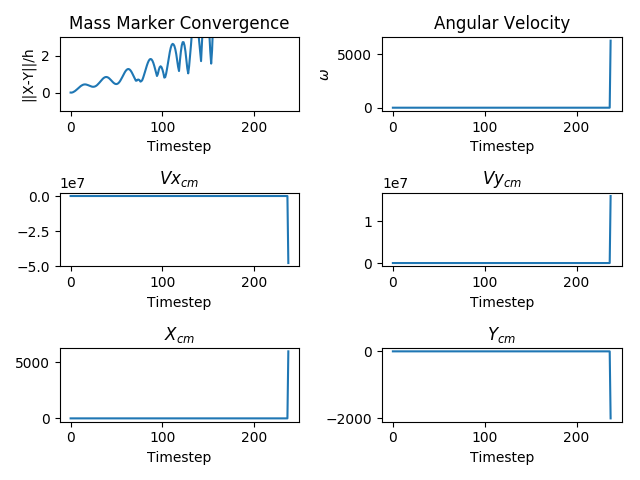

In [10]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(3, 2, 1)
ax1.set_ylim([-1, 3])
ax1.set_title('Mass Marker Convergence')
ax1.set_ylabel('||X-Y||/h')
ax1.set_xlabel('Timestep')
for d in delta: ax1.plot(np.array(d)/fluid.h)
    
ax2 = fig2.add_subplot(3, 2, 2)       
ax2.set_title('Angular Velocity')
ax2.set_ylabel('$\omega$')
ax2.set_xlabel('Timestep')
for i in range(len(insides)): ax2.plot(0.5*dt*np.array(LL[i])/insides[i].I0)
    
ax3 = fig2.add_subplot(3, 2, 3)       
ax3.set_title('$Vx_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(VCM)[i][:, 0])

ax3 = fig2.add_subplot(3, 2, 4)       
ax3.set_title('$Vy_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(VCM)[i][:, 1])
    
ax3 = fig2.add_subplot(3, 2, 5)       
ax3.set_title('$X_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(YCM)[i][:, 0])

ax3 = fig2.add_subplot(3, 2, 6)       
ax3.set_title('$Y_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(YCM)[i][:, 1])
    
fig2.tight_layout()


<IPython.core.display.Javascript object>


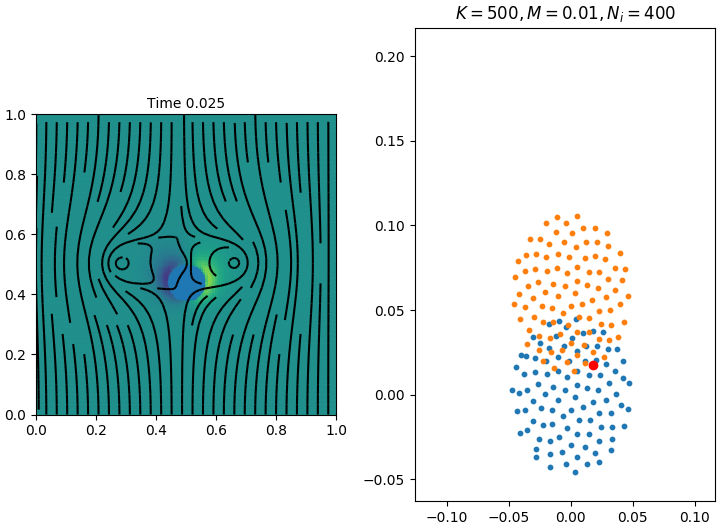

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500


In [7]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    ii = i*nmod
    print(ii)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[ii][:,0]%L, x[ii][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][ii]
        com = np.mean(xin, axis=0)
        ins = xin - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
#         im.append(axj.scatter([ins[-1,0]], [ins[-1,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
        im.append(axj.scatter([yins[-1,0]], [yins[-1,1]], color='red'))  ## Mark theta=0
        
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
#         im.append(ax.set_title('t={}'.format(1*fluid.t)))

        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [8]:
ani3 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)

In [9]:
# ani3.save('rtex_shedding.gif')

<IPython.core.display.Javascript object>


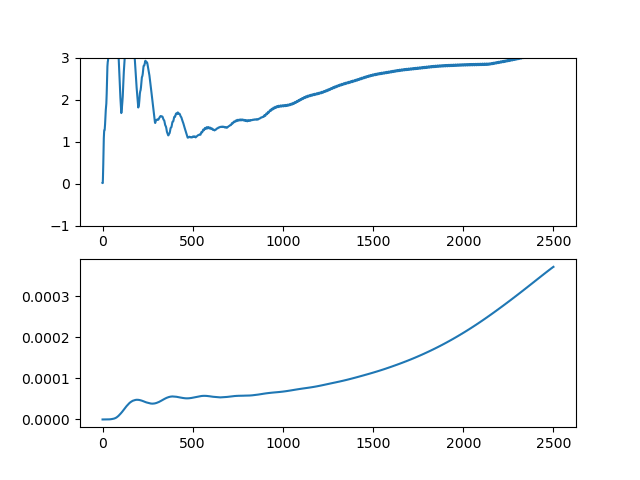

In [34]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(2, 1, 1)
ax1.set_ylim([-1, 3])
for d in delta: ax1.plot(np.array(d)/fluid.h)
    
ax2 = fig2.add_subplot(2, 1, 2)       
for i in range(len(insides)): ax2.plot(0.5*dt*np.array(LL[i])/insides[i].I0)


# An Extension: Poisseuille Flow

We can also use a "control flow" to try and simulate a flow through a channel. This follows the same principle as the sedimentation experiment: we 